In [1]:
import os
import pandas as pd
import numpy as np
import json
import warnings
import random
import torch
import shutil
from tqdm import tqdm
from pathlib import Path

In [2]:
torch.cuda.is_available()

True

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def seed_system(seed=4):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    return seed
seed = seed_system()

In [5]:
def flush_folders(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory) 
    return True

In [6]:
input_data_path =  '/kaggle/input/annotatedpotholesdataset/'
working_dir = '/kaggle/working/annotatedpotholesdataset/'
images_path = Path(input_data_path+'annotated-images/')

make_folders = ['/images','/labels']
train_valid = ['/train','/test']


def create_folder_structure(home=working_dir,make_folders=make_folders,train_valid=train_valid):
    if not os.path.exists(home):
        os.makedirs(home)
    for path in tqdm(make_folders):
        for c in train_valid:
            data_path = home+path+c
            if not os.path.exists(data_path):
                os.makedirs(data_path)
    return True

def copy_data(files,destination):
    for f in files:
        shutil.copy(f,destination)
    return

In [7]:
flush=flush_folders(working_dir)
create_folder_structure()

100%|██████████| 2/2 [00:00<00:00, 1670.04it/s]


True

In [8]:
image_files = [f for f in os.listdir(input_data_path+'annotated-images') if f.endswith('.jpg')]
xml_files = [f for f in os.listdir(input_data_path+'annotated-images') if f.endswith('.xml')]

In [9]:
with open(input_data_path+'splits.json','r') as f:
    split = json.load(f)
    
for key in split.keys():
    list_of_indices = split[key]
    print(key)
    filtered_indices = [input_data_path+'annotated-images/'+i[:-4]+'.jpg' for i in xml_files if i in list_of_indices]
    copy_data(filtered_indices,destination=working_dir+'/images/'+key)
    

train
test


In [10]:
# os.listdir(working_dir+'images/test')

In [11]:
import xml.etree.ElementTree as ET
from pathlib import Path
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_anno_df(anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['image_name'] = root.find("./filename").text[:-4]
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [12]:
df_annotation = generate_anno_df(input_data_path+'annotated-images')

In [13]:
df_annotation.head()

,filename,image_name,width,height,class,xmin,ymin,xmax,ymax
0,/kaggle/input/annotatedpotholesdataset/annotat...,img-564,400,300,pothole,163,205,245,243
1,/kaggle/input/annotatedpotholesdataset/annotat...,img-97,720,720,pothole,245,263,477,348
2,/kaggle/input/annotatedpotholesdataset/annotat...,img-221,720,720,pothole,257,315,387,401
3,/kaggle/input/annotatedpotholesdataset/annotat...,img-502,450,300,pothole,86,53,148,73
4,/kaggle/input/annotatedpotholesdataset/annotat...,img-86,720,720,pothole,230,282,395,395


In [14]:
train_indices = [f[:-4] for f in os.listdir(working_dir+'images/train')]
valid_indices = [f[:-4] for f in os.listdir(working_dir+'images/test')]
df_annotation_train = df_annotation[df_annotation.image_name.isin(train_indices)]
df_annotation_valid = df_annotation[df_annotation.image_name.isin(valid_indices)]

In [15]:
def get_annotations_to_txt(df_anno,mode):
    for image in list(df_anno.image_name.unique()):
        df_to_txt = df_anno[df_anno.image_name==image]
        df_to_txt.to_csv(working_dir+'labels/'+mode+'/'+image+'.txt', sep=' ', index=False, header=False)
    return True

_ = get_annotations_to_txt(df_annotation_train,mode='train')
_ = get_annotations_to_txt(df_annotation_valid,mode='test')

In [16]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
1.6.0 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [17]:
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 5.6 MB 364 kB/s eta 0:00:01
     |████████████████████████████████| 47 kB 3.5 MB/s  eta 0:00:01
  Using cached pycocotools-2.0.7-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (403 kB)
     |████████████████████████████████| 79 kB 7.1 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB 918 kB/s  eta 0:00:01
     |████████████████████████████████| 117 kB 74.2 MB/s eta 0:00:01
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-py3-none-any.whl size=58540 sha256=bb423c346218dfebecd10c4f64f070c2e09ca9fd77c74e1563eca8051f13fc79
  Stored in directory: /root/.cache/pip/wheels/a6/02/09/10e3a0150eb92e5ecbee3677a813bffc32a8ec6f876bfe4adf
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31542 sha256=86ae0dfdb3b40f6928f2257475712102d730b573ee9b20be9a4706c8bfdf2d6a
  Stored in directory: /root/.cache/pip/wheel

In [18]:
from detectron2.structures import BoxMode
import cv2 as cv

label_folder = working_dir + 'labels/'
image_folder = working_dir + 'images/'

def prepare_dataset(path,image_folder=image_folder,label_folder=label_folder):
    list_dataset = []
    files = os.listdir(label_folder+path)
    print("Number of lables in", path, str(len(files)))
    for i,file in enumerate(files):
        try:
            all_vals = []
            with open(label_folder+path+file,'r') as f:
                all_vals.append(f.readlines())
                f.close()
            all_vals = [line.split() for line in all_vals[0]]
            master_dict = {}
            annotations = []
            for i,vals in enumerate(all_vals):
                image_id = file[:-4]
                #label_file_name = label_folder+path+file
                image_file_name= vals[0]
                width,height = int(vals[2]),int(vals[3])
                label = vals[4]
                x_min,y_min = int(vals[5]),int(vals[6])
                x_max,y_max = int(vals[7]),int(vals[8])
                bbox = [x_min,y_min,x_max,y_max]

                obj = {
                    "bbox": [x_min, y_min,x_max, y_max],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": 0,
                }
                annotations.append(obj)
                master_dict['file_name']=image_file_name
                master_dict['image_id'] = image_id
                master_dict['height'] = height
                master_dict['width'] = width
        except Exception as e:
            print(e)
        master_dict['annotations'] = annotations
        list_dataset.append(master_dict)
    return list_dataset


def prepare_master_dict(path):

    unique_image_id_train = list(set(os.listdir(image_folder+path)))
    unique_image_id_train = [i[:-4] for i in unique_image_id_train]
    
    list_dataset = prepare_dataset(path=path)
    return list_dataset

In [19]:
#/kaggle/input/annotatedpotholesdataset/annotated-images/img-430.jpg img-430 451 300 pothole 225 230 371 277


In [20]:
list_dataset = prepare_master_dict(path='test/')

Number of lables in test/ 133


In [21]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [22]:
for d in ["train/", "test/"]:
    DatasetCatalog.register("bc_v7_" + d, lambda d=d: prepare_master_dict(path=d))
    MetadataCatalog.get("bc_v7_" + d).set(thing_classes=['pothole'])

{'file_name': '/kaggle/input/annotatedpotholesdataset/annotated-images/img-211.jpg', 'image_id': 'img-211', 'height': 720, 'width': 720, 'annotations': [{'bbox': [234, 262, 532, 438], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0}]}


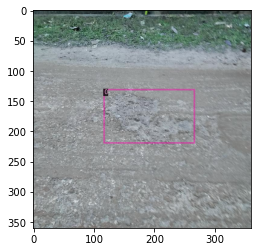

In [23]:
import random
import matplotlib.pyplot as plt
valid_metadata = MetadataCatalog.get("bc_v7_" + 'test')
for d in random.sample(list_dataset, 1):
    print(d)
    img = cv.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=valid_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [25]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
setup_logger()

model_yaml =  "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_yaml))
cfg.DATASETS.TRAIN = ("bc_v7_train/",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_yaml)  
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0005  
cfg.SOLVER.MAX_ITER = 1000  
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


[09/29 07:24:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:01, 210MB/s]                             


[09/29 07:24:55 d2.engine.train_loop]: Starting training from iteration 0
[09/29 07:25:09 d2.utils.events]:  eta: 0:11:49  iter: 19  total_loss: 1.657  loss_cls: 0.7296  loss_box_reg: 0.8554  loss_rpn_cls: 0.06559  loss_rpn_loc: 0.008641  time: 0.6791  data_time: 0.0375  lr: 9.9905e-06  max_mem: 6850M
[09/29 07:25:23 d2.utils.events]:  eta: 0:11:29  iter: 39  total_loss: 1.529  loss_cls: 0.6483  loss_box_reg: 0.792  loss_rpn_cls: 0.04837  loss_rpn_loc: 0.008717  time: 0.6831  data_time: 0.0236  lr: 1.998e-05  max_mem: 6850M
[09/29 07:25:37 d2.utils.events]:  eta: 0:11:15  iter: 59  total_loss: 1.417  loss_cls: 0.5656  loss_box_reg: 0.7637  loss_rpn_cls: 0.04114  loss_rpn_loc: 0.00848  time: 0.6931  data_time: 0.0272  lr: 2.997e-05  max_mem: 6850M
[09/29 07:25:51 d2.utils.events]:  eta: 0:11:00  iter: 79  total_loss: 1.418  loss_cls: 0.5055  loss_box_reg: 0.8358  loss_rpn_cls: 0.0495  loss_rpn_loc: 0.009646  time: 0.6959  data_time: 0.0228  lr: 3.9961e-05  max_mem: 6850M
[09/29 07:26:06

In [26]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.DATASETS.TEST = ("bc_v7_test/", )
predictor = DefaultPredictor(cfg)

Number of lables in test/ 133


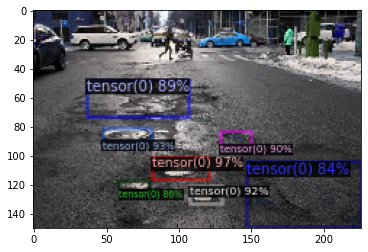

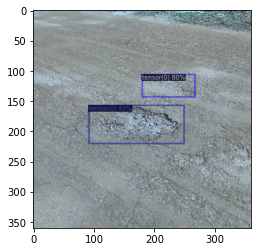

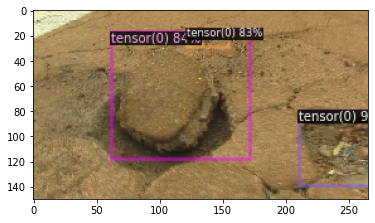

In [27]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = prepare_master_dict(path='test/')

for d in random.sample(dataset_dicts, 3):    
    im = cv.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=valid_metadata, 
                   scale=0.5, 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:,:,::-1])
    plt.show()

In [28]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("bc_v7_test/", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "bc_v7_test/")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [09/29 07:36:53 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/29 07:36:53 d2.evaluation.coco_evaluation]: 'bc_v7_test/' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[09/29 07:36:53 d2.data.datasets.coco]: Converting annotations of dataset 'bc_v7_test/' to COCO format ...)
Number of lables in test/ 133
[09/29 07:36:53 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[09/29 07:36:53 d2.data.datasets.coco]: Conversion finished, #images: 133, #annotations: 133
[09/29 07:36:53 d2.data.datasets.coco]: Caching COCO format annotations at './output/bc_v7_test/_coco_format.json' ...
Number of lables in test/ 133
[09/29 07:36:53 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  pothole   | 133          |
|            |              |
[09/29

In [29]:
from detectron2.modeling import build_model
model = build_model(cfg)  

In [30]:
model

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock